In [ ]:
# Author and date
import datetime, getpass
user = dj.config['database.user']
print(user, datetime.datetime.today())

In [1]:
# Author and date
import datetime, getpass
%matplotlib inline
from ipywidgets import Image
from matplotlib import pyplot as plt

import datajoint as dj

In [2]:
user = dj.config['database.user']
schema = dj.schema(f'{user}_states')

Connecting megan@db.data-science-ust.net:3306


In [3]:
states = dict(
    AL='Alabama',        AK='Alaska',       AZ='Arizona',      AR='Arkansas',
    CA='California',     CO='Colorado',     CT='Connecticut',  DE='Delaware',
    FL='Florida',        GA='Georgia',      HI='Hawaii',       ID='Idaho', 
    IL='Illinois',       IN='Indiana',      IA='Iowa',         KS='Kansas',
    KY='Kentucky',       LA='Louisiana',    ME='Maine',        MD='Maryland',
    MA='Massachusetts',  MI='Michigan',     MN='Minnesota',    MS='Mississippi',
    MO='Missouri',       MT='Montana',      NE='Nebraska',     NV='Nevada',
    NH='New Hampshire',  NJ='New Jersey',   NM='New Mexico',   NY='New York',
    NC='North Carolina', ND='North Dakota', OH='Ohio',         OK='Oklahoma',
    OR='Oregon',         PA='Pennsylvania', RI='Rhode Island', SC='South Carolina',
    SD='South Dakota',   TN='Tennessee',    TX='Texas',        UT='Utah',
    VT='Vermont',        VA='Virginia',     WA='Washington',   WV='West Virginia', 
    WI='Wisconsin',      WY='Wyoming')

In [4]:
@schema
class State(dj.Lookup):
    definition = """
    # United States
    state_code : char(2)
    ---
    state : varchar(20)
    """
    contents = states.items()

In [5]:
State()

state_code,state
AK,Alaska
AL,Alabama
AR,Arkansas
AZ,Arizona
CA,California
CO,Colorado
CT,Connecticut
DE,Delaware
FL,Florida
GA,Georgia


In [6]:
form = {'state': 'newyork'}
Image.from_url("http://www.theus50.com/images/state-birds/{state}-bird.jpg".format(**form))

Image(value=b'http://www.theus50.com/images/state-birds/newyork-bird.jpg', format='url')

In [7]:
Image.from_url("http://www.theus50.com/images/state-flags/{state}-flag.jpg".format(**form))

Image(value=b'http://www.theus50.com/images/state-flags/newyork-flag.jpg', format='url')

In [8]:
Image.from_url("http://www.theus50.com/images/state-flowers/{state}-flower.jpg".format(**form))

Image(value=b'http://www.theus50.com/images/state-flowers/newyork-flower.jpg', format='url')

In [9]:
import requests

@schema
class StateBird(dj.Imported):
    definition = """
    -> State
    ---
    bird_image : longblob    
    """
    
    url_template = "http://www.theus50.com/images/state-birds/{state}-bird.jpg"
    
    def make(self, key):
        state = (State & key).fetch1('state')
        url = self.url_template.format(state=state.lower().replace(' ', ''))
        temp_file = 'tmp.jpg'
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, bird_image=plt.imread(temp_file)))

In [10]:
StateBird().populate(display_progress=True, suppress_errors=True)

100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


[]

In [11]:
import requests

@schema
class StateFlag(dj.Imported):
    definition = """
    -> State
    ---
    flag_image : longblob    
    """
    
    url_template = "http://www.theus50.com/images/state-flags/{state}-flag.jpg"
    
    def make(self, key):
        state = (State & key).fetch1('state')
        url = self.url_template.format(state=state.lower().replace(' ', ''))
        temp_file = 'tmp.jpg'
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, flag_image=plt.imread(temp_file)))

In [12]:
StateFlag.populate(display_progress=True)

100%|██████████| 50/50 [00:07<00:00,  6.68it/s]


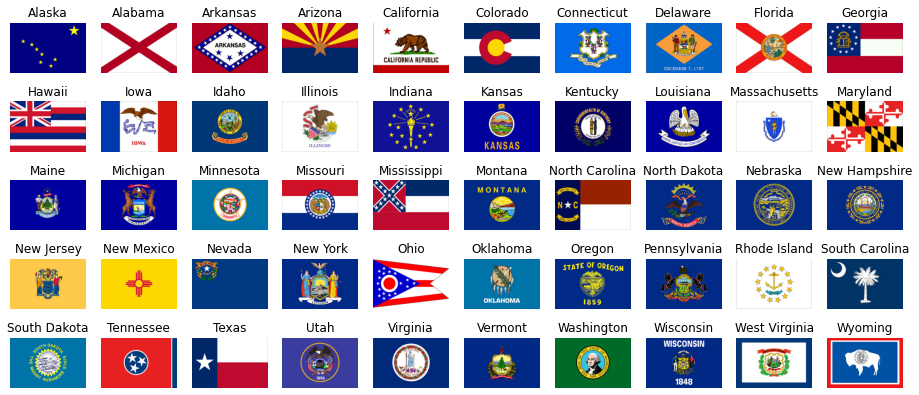

In [13]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State).fetch(as_dict=True)):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)

In [19]:
import colorsys
@schema
class StateFlagHSV(dj.Computed):
    definition = """
    -> StateFlag
    ---
    hue: float
    sat: float
    value: float
    """
    
    def make(self,key):
        img = (StateFlag & key).fetch1('flag_image')
        hue,sat,value = colorsys.rgb_to_hsv(*img.mean(axis = (0,1))/255)
        self.insert1(dict(key, hue=hue, sat=sat, value=value))

In [20]:
StateFlagHSV.populate()

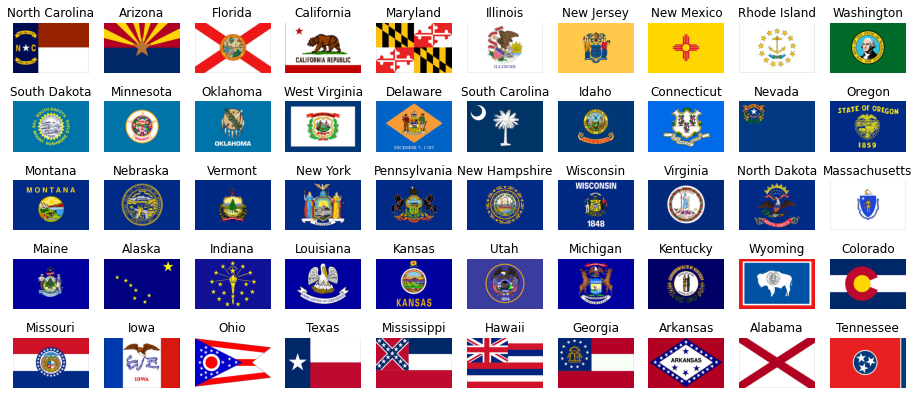

In [21]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State*StateFlagHSV).fetch(as_dict=True, order_by = 'hue')):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)